In [1]:
DATE = "2022-01-30"
TASK = "sample-core-genome-100"
DIR = mkpath("$(homedir())/workspace/$(DATE)-$(TASK)")
cd(DIR)

In [8]:
pkgs = [
    "Graphs",
    "MetaGraphs",
    "FileIO",
    "JLD2",
    "DataStructures",
    "BioSequences",
    "Random",
    "FASTX",
    "Revise",
    "StatsBase"
]

import Pkg
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(basename(pkg))"))
end

import Mycelia

   Resolving package versions...
  No Changes to `~/.julia/dev/Mycelia/docs/Project.toml`
  No Changes to `~/.julia/dev/Mycelia/docs/Manifest.toml`
┌ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Mycelia.observe :: Tuple{R} where R<:Union{FASTX.FASTA.Record, FASTX.FASTQ.Record}` in module `Mycelia`
└ @ Base.Docs docs/Docs.jl:240


In [9]:
function update_remaining_targets(current_walk::AbstractVector{T}, remaining_targets::AbstractSet{T}) where T <: BioSequences.AbstractMer
    # assess whether targets have been hit in the canonical space
    remaining_targets = setdiff(BioSequences.canonical.(remaining_targets), BioSequences.canonical.(current_walk))
    # blow back out into forward and reverse_complement space
    remaining_targets = Set{T}(vcat(remaining_targets, BioSequences.reverse_complement.(remaining_targets)))
    return remaining_targets
end

update_remaining_targets (generic function with 1 method)

In [10]:
# vertices should either be entire graph (by default) or a connected component
# if people want to work on just the connected component, let them induce a subgraph
function find_graph_core(graph; seed=rand(Int))
    
    Random.seed!(seed)
    
#     T = typeof(MetaGraphs.get_prop(graph, 1, :kmer))
    
    selected_nodes = Set([
        MetaGraphs.get_prop(graph, i, :kmer) for (i, v) in enumerate(Graphs.vertices(graph))
            if Graphs.degree(graph, v) >= 3])
    # take the hub nodes!
#     selected_nodes = [
#         MetaGraphs.get_prop(graph, i, :kmer) for (i, v) in enumerate(Graphs.vertices(graph))
#             if Graphs.degree(graph, v) >= 3]
#     selected_node_counts = [MetaGraphs.get_prop(graph, :kmer_counts)[kmer] for kmer in selected_nodes]
#     max_value, index = findmax(selected_node_counts)
#     starting_node = selected_nodes[index]
#     starting_node = StatsBase.sample(selected_nodes, StatsBase.weights(selected_node_counts))
    
    max_kmer_count = MetaGraphs.get_prop(graph, 1, :count)
    starting_kmer = MetaGraphs.get_prop(graph, 1, :kmer)
    for i in 2:Graphs.nv(graph)
        this_count = MetaGraphs.get_prop(graph, i, :count)
        if this_count > max_kmer_count
            max_kmer_count = this_count
            starting_kmer = MetaGraphs.get_prop(graph, i, :kmer)
        end
    end
    
    current_walk = [starting_kmer]
    prior_walk_length = length(current_walk)
    
    remaining_targets = update_remaining_targets(current_walk, selected_nodes)
#     @show current_walk
#     @show remaining_targets
    
#     targets = setdiff(selected_nodes, current_walk)
#     remaining_targets = Set{T}(vcat(targets, BioSequences.reverse_complement.(targets)))
    done = isempty(remaining_targets)
    
    while !done
        forward_source = last(current_walk)
        reverse_source = BioSequences.reverse_complement(first(current_walk))
        
        forward_walk, forward_distance = Mycelia.dijkstra(graph, forward_source, remaining_targets, search_strategy=:DFS)
#         current_walk = vcat(current_walk, forward_walk[2:end])
#         remaining_targets = update_remaining_targets(current_walk, remaining_targets)
#         @show current_walk
#         @show remaining_targets
        reverse_walk, reverse_distance = Mycelia.dijkstra(graph, reverse_source, remaining_targets, search_strategy=:DFS)
#         current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk)
        current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk, forward_walk[2:end])
        remaining_targets = update_remaining_targets(current_walk, remaining_targets)

#         @show current_walk
#         @show remaining_targets
        
#         # assess whether targets have been hit in the canonical space
#         remaining_targets = setdiff(BioSequences.canonical.(remaining_targets), BioSequences.canonical.(current_walk))
#         # blow back out into forward and reverse_complement space
#         remaining_targets = Set{T}(vcat(remaining_targets, BioSequences.reverse_complement.(remaining_targets)))    
        failed_this_expansion = length(current_walk) == prior_walk_length
        prior_walk_length = length(current_walk)
        
        if isempty(remaining_targets)
            done = true
        elseif failed_this_expansion
            done = true
        end
    end

#     @show current_walk
    # if we haven't closed a loop, try and walk out to ends of contigs/chromosomes
    if first(current_walk) != last(current_walk)
        forward_source = last(current_walk)
        reverse_source = BioSequences.reverse_complement(first(current_walk))
        forward_walk, forward_distance = Mycelia.dijkstra(graph, forward_source, remaining_targets, search_strategy=:DFS)
        reverse_walk, reverse_distance = Mycelia.dijkstra(graph, reverse_source, remaining_targets, search_strategy=:DFS)
        current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk, forward_walk[2:end])
    end
    return current_walk
end     

find_graph_core (generic function with 1 method)

In [12]:
# Create a reference sequence
L = 100
record = Mycelia.random_fasta_record(seed=0, L=L)
# record = random_fasta_record(seed=0, L=L)

FASTX.FASTA.Record:
   identifier: p6dJ7
  description: <missing>
     sequence: AAGGGTGCGGTCTAGGTGCACTGCTTATGGTCCCCGACA…

In [13]:
function observe(records::AbstractVector{R};
                weights=ones(length(records)),
                N = length(records),
                outfile = "",
                error_rate = 0.0) where {R <: Union{FASTX.FASTA.Record, FASTX.FASTQ.Record}}
    if isempty(outfile)
        error("no file name supplied")
    end
    io = open(outfile, "w")
    fastx_io = FASTX.FASTA.Writer(io)
    for i in 1:N
        record = StatsBase.sample(records, StatsBase.weights(weights))
        new_seq = Mycelia.observe(FASTX.sequence(record), error_rate=error_rate)
        new_seq_id = Random.randstring(Int(ceil(log(length(new_seq) + 1))))
        new_seq_description = FASTX.identifier(record)
        observed_record = FASTX.FASTA.Record(new_seq_id, new_seq_description, new_seq)
        write(fastx_io, observed_record)
    end
    close(fastx_io)
    close(io)
    return outfile
end

observe (generic function with 1 method)

In [124]:
error_rate = 1/(2^10)

0.0009765625

In [125]:
fasta_file = "$(DIR)/N-$L.observations.fasta"
observe([record], N=L, outfile=fasta_file, error_rate=error_rate)

"/home/jupyter-cjprybol/workspace/2022-01-30-sample-core-genome-100/N-100.observations.fasta"

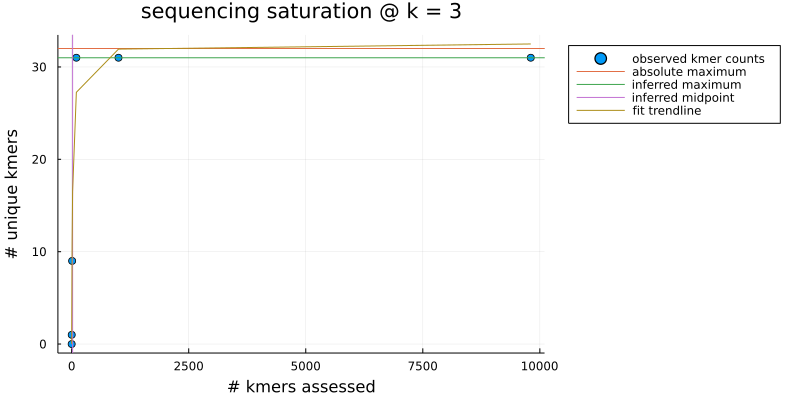

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9806], [0, 1, 9, 31, 31, 31], true)
  0.000661 seconds (378 allocations: 38.422 KiB)
(k, predicted_saturation) = (3, 0.96875)


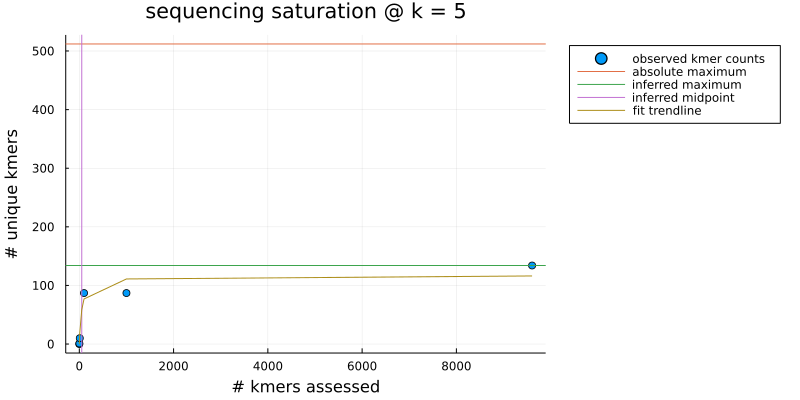

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9606], [0, 1, 10, 87, 87, 134], true)
  0.000147 seconds (246 allocations: 24.922 KiB)
(k, predicted_saturation) = (5, 0.26171875)


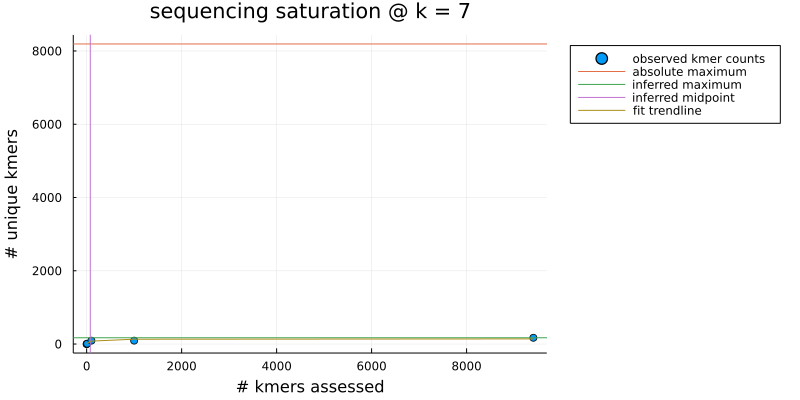

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 9406], [0, 1, 10, 93, 93, 171], true)
  0.000178 seconds (290 allocations: 29.422 KiB)
(k, predicted_saturation) = (7, 0.0208740234375)
chosen k = 7


7

In [126]:
chosen_k = Mycelia.assess_kmer_saturation([fasta_file]; outdir="$(observations_file).kmer-assessements")

In [127]:
T = BioSequences.BigDNAMer{chosen_k}
# T = BioSequences.BigDNAMer{chosen_k}
# T = BioSequences.BigDNAMer{61}

BioSequences.BigDNAMer{7} (alias for BioSequences.BigMer{BioSequences.DNAAlphabet{2}, 7})

In [128]:
graph = Mycelia.fastx_to_kmer_graph(T, fasta_file)

  0.003536 seconds (2.47 k allocations: 920.844 KiB)


┌ Info: counting kmers
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:78
┌ Info: initializing graph
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:81
┌ Info: adding node metadata
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:91


{171, 183} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [129]:
Mycelia.graph_to_gfa(graph, "$(fasta_file).gfa")

"/home/jupyter-cjprybol/workspace/2022-01-30-sample-core-genome-100/N-100.observations.fasta.gfa"

In [ ]:
# open in bandage

In [130]:
FASTX.sequence(record)

100nt DNA Sequence:
AAGGGTGCGGTCTAGGTGCACTGCTTATGGTCCCCGACA…TCTACCTCTTTGTTGAAACGTATTCTTCTCTTAACACCT

In [135]:
join(map(kmer -> graph[kmer, :kmer], BioSequences.canonical.(BioSequences.each(T, FASTX.sequence(record)))), ',')

"16,55,105,98,31,128,42,110,116,102,33,82,135,57,148,58,88,136,52,15,121,60,89,92,29,126,70,143,144,109,168,93,94,97,104,125,26,87,54,36,83,32,101,99,31,81,140,65,20,151,61,131,47,84,165,66,132,48,164,133,67,56,115,45,13,4,74,22,6,75,166,171,156,158,113,38,2,9,18,112,40,11,71,39,129,43,12,160,120,155,123,153,149,7"

In [139]:
join(map(kmer -> string(graph[BioSequences.canonical(kmer), :kmer]) * (BioSequences.iscanonical(kmer.fw) ? '+' : '-'), collect(BioSequences.each(T, FASTX.sequence(record)))), ',')

"16+,55+,105-,98-,31-,128-,42-,110+,116-,102-,33-,82-,135-,57+,148+,58-,88-,136+,52-,15-,121+,60-,89-,92-,29-,126-,70+,143-,144-,109-,168+,93+,94+,97+,104-,125+,26+,87+,54+,36-,83-,32+,101+,99-,31-,81-,140+,65-,20-,151+,61-,131-,47-,84-,165+,66-,132-,48-,164-,133+,67+,56-,115+,45-,13-,4-,74-,22-,6-,75-,166-,171+,156+,158-,113-,38-,2+,9+,18-,112+,40-,11-,71+,39-,129-,43-,12-,160-,120+,155-,123+,153-,149-,7+"

In [ ]:
AAGGGTGCGGTCTAGGTGCACTGCTTATGGTCCCCGACAGGACCGTGCGGTGATTATCTGATCTACCTCTTTGTTGAAACGTATTCTTCTCTTAACACCT

In [ ]:
# load graph

In [ ]:
# 

In [ ]:
highlight known core path

In [ ]:
infer core path

In [ ]:
highlight that too

In [ ]:
seed = 0
core_path = find_graph_core(graph, seed=seed)

In [ ]:
selected_vertices = map(canonical_kmer -> graph[canonical_kmer, :kmer], unique(BioSequences.canonical.(core_path)))
subgraph, vertex_map = Graphs.induced_subgraph(graph, selected_vertices)
Mycelia.plot_graph(subgraph)

In [ ]:
reconstruted_sequence = kmer_path_to_sequence(core_path)

In [ ]:
refseq

In [ ]:
seed += 1
@show seed
core_path = find_graph_core(graph, seed=seed)